In [7]:
import os
import cv2
import json
import shutil
import random
import numpy as np
import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from src.create_annotations import *
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.patches as patches


In [4]:
# Label ids of the dataset
category_ids = {
    "non": 0,
    "affected": 1,
}

# Define which colors match which categories in the images
category_colors = {
    "(0, 0, 0)": 0, # normal
    "(255, 255, 255)": 1, # affected
}

# Define the ids that are a multipolygon.
multipolygon_ids = [1]

In [6]:
# Get "images" and "annotations" info
def images_annotations_info(maskpath):
    # This id will be automatically increased as we go
    annotation_id = 0
    image_id = 0
    annotations = []
    images = []
    
    for mask_image in glob.glob(maskpath + "*.png"):
        # The mask image is *.png but the original image is *.jpg.

        original_file_name = os.path.basename(mask_image).split("_segmentation.")[0] + ".jpg"

        # Open the image and (to be sure) we convert it to RGB
        mask_image_open = Image.open(mask_image).convert("RGB")
        w, h = mask_image_open.size
        
        # "images" info 
        image = create_image_annotation(original_file_name, w, h, image_id)
        images.append(image)

        sub_masks = create_sub_masks(mask_image_open, w, h)
        has_class_1 = False
        for color, sub_mask in sub_masks.items():
            category_id = category_colors[color]

            # "annotations" info
            polygons, segmentations = create_sub_mask_annotation(sub_mask)

            # Check if we have classes that are a multipolygon
            if category_id in multipolygon_ids:
                # Combine the polygons to calculate the bounding box and area
                multi_poly = MultiPolygon(polygons)
                                
                annotation = create_annotation_format(multi_poly, segmentations, image_id, category_id, annotation_id)

                annotations.append(annotation)
                annotation_id += 1
            else:
                for i in range(len(polygons)):
                    # Cleaner to recalculate this variable
                    segmentation = [np.array(polygons[i].exterior.coords).ravel().tolist()]
                    
                    annotation = create_annotation_format(polygons[i], segmentation, image_id, category_id, annotation_id)
                    
                    annotations.append(annotation)
                    annotation_id += 1
                    if category_id == 1:
                        has_class_1 = True
        if not has_class_1:
            # Add a background annotation for the entire image
            annotation = create_annotation_format(Polygon([(0, 0), (w, 0), (w, h), (0, h)]), [[0, 0, w, 0, w, h, 0, h]], image_id, 0, annotation_id)
            annotations.append(annotation)
            annotation_id += 1

        image_id += 1
    return images, annotations, annotation_id



In [7]:
if __name__ == "__main__":
    # Get the standard COCO JSON format
    coco_format = get_coco_json_format()
    
    for keyword in ["input_images"]:
        mask_path = "dataset/{}_mask/".format(keyword)
        
        # Create category section
        coco_format["categories"] = create_category_annotation(category_ids)
    
        # Create images and annotations sections
        coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_path)

        output_dir = "dataset/output/"
        os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist

        with open(os.path.join(output_dir, "{}.json".format(keyword)), "w") as outfile:
            json.dump(coco_format, outfile)

        print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_path))


Created 197 annotations for images in folder: dataset/input_images_mask/


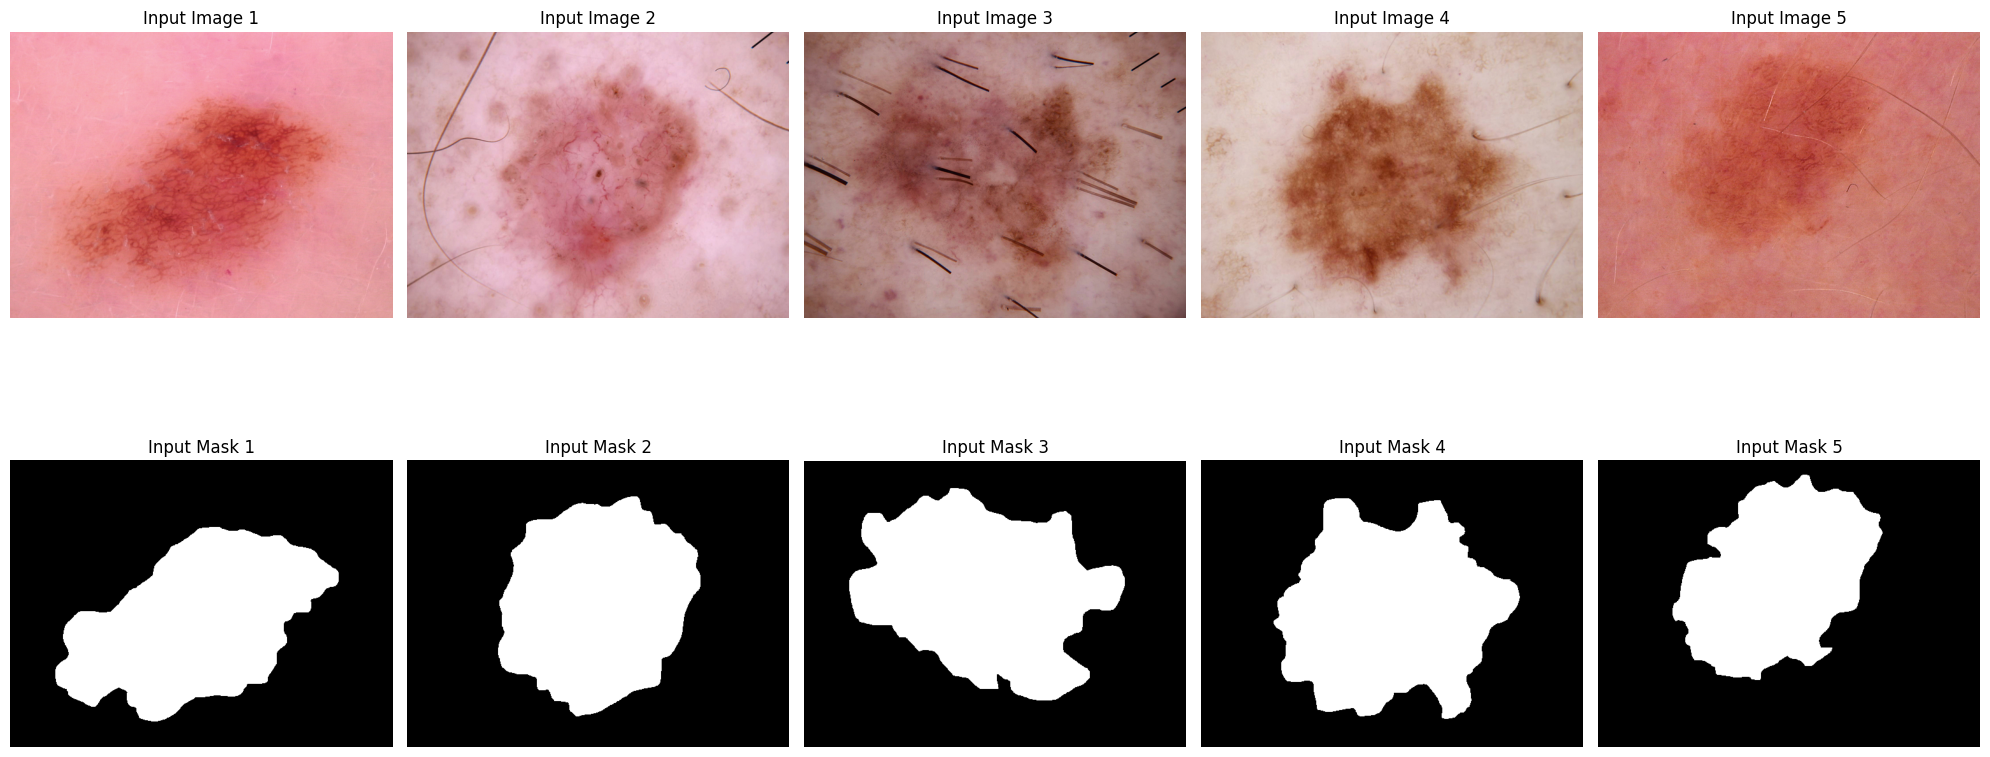

In [5]:
# Path to the dataset directory
dataset_dir = "dataset/"

# Path to the input images and masks directories
input_images_dir = os.path.join(dataset_dir, "input_images/")
input_masks_dir = os.path.join(dataset_dir, "input_images_mask/")

# Get the list of files in the input images directory
input_image_files = os.listdir(input_images_dir)

# Select 5 random image files
random_image_files = random.sample(input_image_files, 5)

# Display the images and masks
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i, random_image_file in enumerate(random_image_files):
    # Load and display the input image
    input_image_path = os.path.join(input_images_dir, random_image_file)
    input_image = plt.imread(input_image_path)

    # Load and display the corresponding input mask
    random_mask_file = random_image_file.replace(".jpg", "_segmentation.png")
    input_mask_path = os.path.join(input_masks_dir, random_mask_file)
    input_mask = plt.imread(input_mask_path)

    axes[0, i].imshow(input_image)
    axes[0, i].set_title(f"Input Image {i+1}")
    axes[0, i].axis('off')

    axes[1, i].imshow(input_mask, cmap='gray')
    axes[1, i].set_title(f"Input Mask {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


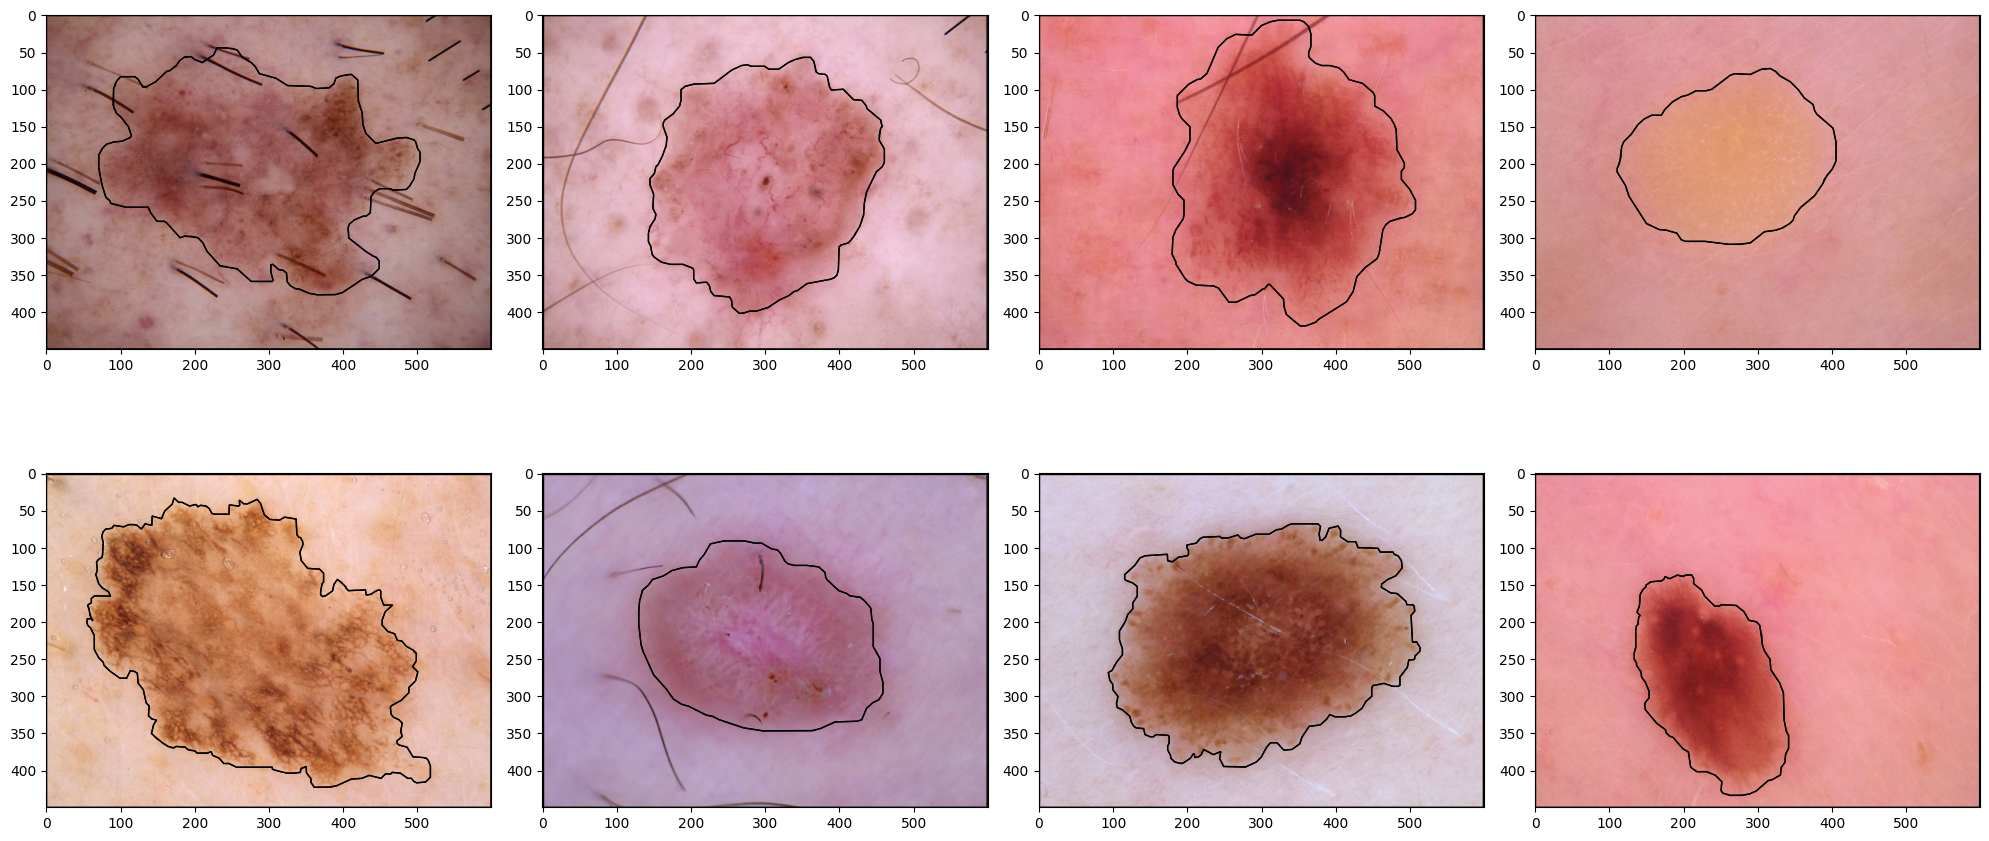

In [16]:
def display_images_with_coco_annotations(image_paths, annotations, display_type='both', colors=None):
    # Create a 2x4 grid of subplots for displaying images
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    
    for ax_row, row_images in zip(axs, image_paths):
       
        for ax, img_path in zip(ax_row, row_images):
           
            image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            ax.imshow(image)
            ax.axis('on')

            # Find the image ID for the current image path
            img_filename = os.path.basename(img_path)
            img_id = next(item['id'] for item in annotations['images'] if item["file_name"] == img_filename)
            
            # Get the annotations for the current image ID
            img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]
            
            # Iterate over each annotation and display bounding boxes or segmentations
            for ann in img_annotations:
                if display_type in ['bbox', 'both']:
                    bbox = ann['bbox']
                    ax.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='black', facecolor='none'))
                
                if display_type in ['seg', 'both']:
                    for seg in ann['segmentation']:
                        poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                        ax.add_patch(patches.Polygon(poly, closed=True, edgecolor='black', fill=False))
                        
    plt.tight_layout()
    plt.show()

# Load annotations from the JSON file
with open('dataset/output/input_images.json', 'r') as f:
    annotations = json.load(f)

# Select 8 random image files
image_dir = "dataset/input_images/"
image_files = random.sample([os.path.join(image_dir, img['file_name']) for img in annotations['images']], 8)

# Reshape the list of image files into a 2x4 grid
image_files = [image_files[i:i+4] for i in range(0, len(image_files), 4)]

# Display images with COCO annotations
display_images_with_coco_annotations(image_files, annotations, 'seg')


In [21]:


source_dir = 'dataset\input_images'
output_dir = 'Yolov5_dataset/'
train_dir = 'Yolov5_dataset/train/'
test_dir = 'Yolov5_dataset/test/'
val_dir = 'Yolov5_dataset/val/'

split_percentage_train = 0.8
split_percentage_test = 0.1

# Create output, train, test, and val directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Get a list of all the image files
files = os.listdir(source_dir)
random.seed(123)  # Set a fixed random seed
random.shuffle(files)  # Shuffle the files for random splitting

# Calculate the number of files for each split
num_train = int(len(files) * split_percentage_train)
num_test = int(len(files) * split_percentage_test)
num_val = len(files) - num_train - num_test

# Split the files into train, test, and val sets
train_files = files[:num_train]
test_files = files[num_train:num_train + num_test]
val_files = files[num_train + num_test:]

# Copy files to the respective directories
for file in train_files:
    shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, file))
for file in test_files:
    shutil.copy(os.path.join(source_dir, file), os.path.join(test_dir, file))
for file in val_files:
    shutil.copy(os.path.join(source_dir, file), os.path.join(val_dir, file))


In [22]:
import json
import os

def coco_to_yolo(coco_annotation_path, output_dir):
    with open(coco_annotation_path, 'r') as f:
        coco_annotations = json.load(f)

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    for image_info in coco_annotations['images']:
        img_id = image_info['id']
        img_name = image_info['file_name']
        img_annotations = [ann for ann in coco_annotations['annotations'] if ann['image_id'] == img_id]

        yolo_annotations = []
        for ann in img_annotations:
            bbox = ann['bbox']
            x_center = bbox[0] + bbox[2] / 2
            y_center = bbox[1] + bbox[3] / 2
            width = bbox[2]
            height = bbox[3]

            yolo_annotations.append(f"{ann['category_id']} {x_center} {y_center} {width} {height}")

        with open(os.path.join(output_dir, os.path.splitext(img_name)[0] + '.txt'), 'w') as f:
            f.write('\n'.join(yolo_annotations))

coco_annotation_path = 'dataset\output\input_images.json'
output_dir = 'Yolov5_dataset/yolo'
coco_to_yolo(coco_annotation_path, output_dir)
